# Environment Setup

In [188]:
import pathlib
import IPython.display as display
import random
import pandas as pd
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
import time
from keras.callbacks import ModelCheckpoint
from random import choice, sample
from PIL import Image
import numpy as np
from tensorflow import keras
import matplotlib as plt

ModuleNotFoundError: No module named 'matplotlib'

In [14]:
%cd C:\Users\xl3036\Documents\ML_Climate_data

C:\Users\xl3036\Documents\ML_Climate_data


In [15]:
%ls

 Volume in drive C is Windows
 Volume Serial Number is CC9A-6545

 Directory of C:\Users\xl3036\Documents\ML_Climate_data

12/14/2022  06:06 PM    <DIR>          .
12/14/2022  06:06 PM    <DIR>          ..
12/14/2022  04:40 PM         1,432,177 train_v2.csv
12/14/2022  05:57 PM    <DIR>          train-jpg
               1 File(s)      1,432,177 bytes
               3 Dir(s)  550,607,867,904 bytes free


In [ ]:
#!tar -xvf 'train-jpg.tar'

# Training Set

In [24]:
data_root = pathlib.Path("C:\\Users\\xl3036\\Documents\\ML_Climate_data\\train-jpg")

In [25]:
all_img_paths = list(data_root.glob('*'))

In [26]:
all_img_paths = [str(path) for path in all_img_paths]

In [27]:
len(all_img_paths)

40479

In [28]:
all_img_paths[:5]

['C:\\Users\\xl3036\\Documents\\ML_Climate_data\\train-jpg\\train_0.jpg',
 'C:\\Users\\xl3036\\Documents\\ML_Climate_data\\train-jpg\\train_1.jpg',
 'C:\\Users\\xl3036\\Documents\\ML_Climate_data\\train-jpg\\train_10.jpg',
 'C:\\Users\\xl3036\\Documents\\ML_Climate_data\\train-jpg\\train_100.jpg',
 'C:\\Users\\xl3036\\Documents\\ML_Climate_data\\train-jpg\\train_1000.jpg']

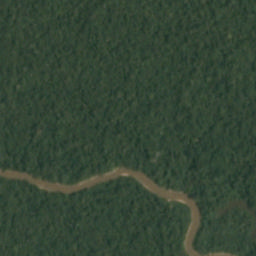

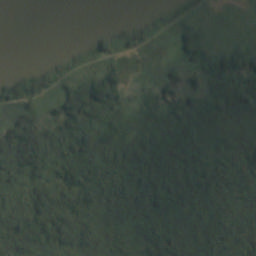

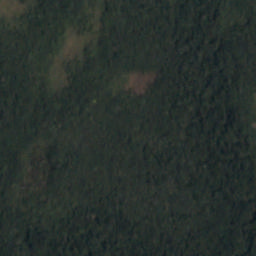

In [ ]:
for n in range(3):
  image_path = random.choice(all_img_paths)
  display.display(display.Image(image_path))

In [30]:
# for testing on the different methods of training using a subset of the data
small_img_paths = sample(all_img_paths, 2000)

In [31]:
len(small_img_paths)

2000

In [36]:
# medium sized dataset for final training that takes a reasonable amount of time
med_img_paths = sample(all_img_paths, 16000)

In [37]:
len(med_img_paths)

16000

# Data Labels

In [38]:
labels = pd.read_csv("train_v2.csv")

In [39]:
labels

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


There is no labels for the test set, since this is a kaggle competition. Will have to split the training set in to train, val, and test.

Here are the label distributions:

In [40]:
tags = defaultdict(lambda: 0)
for each in labels['tags']:
  tag_list = each.split(" ")
  for tag in tag_list:
    tags[tag] += 1

In [41]:
tags

defaultdict(<function __main__.<lambda>()>,
            {'haze': 2697,
             'primary': 37513,
             'agriculture': 12315,
             'clear': 28431,
             'water': 7411,
             'habitation': 3660,
             'road': 8071,
             'cultivation': 4547,
             'slash_burn': 209,
             'cloudy': 2089,
             'partly_cloudy': 7261,
             'conventional_mine': 100,
             'bare_ground': 862,
             'artisinal_mine': 339,
             'blooming': 332,
             'selective_logging': 340,
             'blow_down': 101})

In [42]:
deforest_tags = {}
# these are the tags that we are considering as deforestation
deforestation = ['agriculture', 'cultivation', 'slash_burn', 'conventional_mine', 'artisinal_mine',
                 'selective_logging', 'road', 'habitation']    
for tag, count in tags.items():
  if tag in deforestation:
    deforest_tags[tag] = count

In [43]:
deforest_tags

{'agriculture': 12315,
 'habitation': 3660,
 'road': 8071,
 'cultivation': 4547,
 'slash_burn': 209,
 'conventional_mine': 100,
 'artisinal_mine': 339,
 'selective_logging': 340}

In [44]:
deforestation_count = 0
for each in labels['tags']:
  tag_list = each.split(" ")
  for tag in tag_list:
    if tag in deforest_tags:
      deforestation_count += 1
      break

In [45]:
print("Total counts of deforestation: ", deforestation_count)
print("The percentage of deforestation labels: ", 
      deforestation_count/len(labels))

Total counts of deforestation:  15899
The percentage of deforestation labels:  0.39277156056226686


The dataset is somewhat balanced, with around 40% positive labels (deforestation) and 60% negative labels (no deforestation).

**Binary Data Labels**

First run, try to encode all training example into either has some classification of deforestation or not.

In [46]:
pathlib.Path(all_img_paths[0]).name.split(".")[0]

'train_0'

In [47]:
bin_labels = {} # binary 0/1 labels for whether img has deforestation
i = 0
for each in labels["tags"]:
  tags = each.split(" ")
  for t in tags:
    if t in deforest_tags:
      # 1 for deforestation, 0 for no deforestation
      bin_labels[labels.loc[i]["image_name"]] = 1
      break
  if labels.loc[i]["image_name"] not in bin_labels:
    bin_labels[labels.loc[i]["image_name"]] = 0
  i += 1

In [48]:
# an array of the binary labels to feed into train-test-split
all_bin_labels = [bin_labels[pathlib.Path(path).name.split(".")[0]]
                  for path in all_img_paths]

In [49]:
count = 0
for each in all_bin_labels:
  count += each
print("deforestation: ", count, "\nno deforestation: ", len(all_bin_labels)-count)

deforestation:  15899 
no deforestation:  24580


In [50]:
# DELETE LATER
small_bin_labels = [bin_labels[pathlib.Path(path).name.split(".")[0]]
                  for path in small_img_paths]
count = 0
for each in small_bin_labels:
  count += each
print("deforestation: ", count, "\nno deforestation: ", len(small_bin_labels)-count)
print("The percentage of deforestation labels: ", 
      count/len(small_bin_labels))

deforestation:  797 
no deforestation:  1203
The percentage of deforestation labels:  0.3985


In [51]:
med_bin_labels = [bin_labels[pathlib.Path(path).name.split(".")[0]]
                  for path in med_img_paths]
count = 0
for each in med_bin_labels:
  count += each
print("deforestation: ", count, "\nno deforestation: ", len(med_bin_labels)-count)
print("The percentage of deforestation labels: ", 
      count/len(med_bin_labels))

deforestation:  6319 
no deforestation:  9681
The percentage of deforestation labels:  0.3949375


# Modeling

In [ ]:
train_paths, test_paths, train_labels, test_labels = train_test_split(all_img_paths, 
                                                                      all_bin_labels,
                                                                      test_size=0.25, 
                                                                      random_state=42)

In [96]:
# DELETE LATER
train_paths, test_paths, train_labels, test_labels = train_test_split(small_img_paths, 
                                                                      small_bin_labels,
                                                                      test_size=0.25, 
                                                                      random_state=42)

In [52]:
# DELETE LATER
train_paths, test_paths, train_labels, test_labels = train_test_split(med_img_paths, 
                                                                      med_bin_labels,
                                                                      test_size=0.25, 
                                                                      random_state=42)

Display a few images and their labels

1


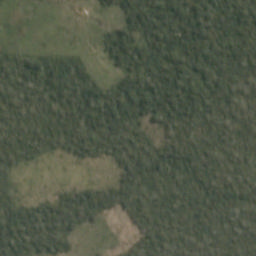


0


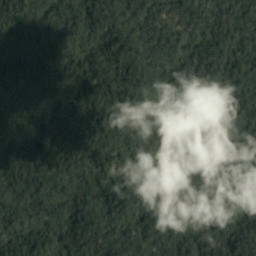


1


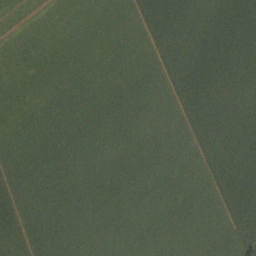

In [55]:
for n in range(3):
  i = random.randint(0,len(train_paths))
  image_path = train_paths[i]
  print(train_labels[i])
  display.display(display.Image(image_path))
  print()

In [ ]:
# img_raw = tf.io.read_file(train_paths[0])
# print(repr(img_raw)[:100]+"...")

In [ ]:
# img_tensor = tf.image.decode_image(img_raw, channels=3, dtype=tf.dtypes.float32)
# print(img_tensor.shape)
# print(img_tensor.dtype)

In [56]:
# Test to see the image dimensions
img_raw = Image.open(train_paths[0]).convert("RGB")
img = img = np.asarray(img_raw) /255

In [57]:
print(img.shape)
print(img.min(), img.max())

(256, 256, 3)
0.047058823529411764 0.615686274509804


**Parameters for loader**

In [58]:
BATCH_SIZE = 128
IMG_SIZE = 180
AUTOTUNE = tf.data.experimental.AUTOTUNE
SHUFFLE_SIZE = 1000
BUFFER_SIZE = 1000

In [59]:
# def load_and_preprocess_image(path):
#   img = tf.io.read_file(path)
#   img = tf.image.decode_jpeg(img, channels=3)
#   img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE ])
#   # img /= 255.0  # normalize pixels to 0,1
#   return img

def load_and_preprocess_image(path):
  img = Image.open(path).convert("RGB")
  img = np.asarray(img) /255
  img = tf.convert_to_tensor(img)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE ])
  return img

In [ ]:
# def load_and_preprocess_image(path):
#   img = iio.imread(path)
#   img = img /255
#   img = tf.convert_to_tensor(img)
#   img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE ])
#   return img

Checking the shapes of the preprocessed dataset:

In [ ]:
# a dataset that returns image paths
# path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
# for n, img_path in enumerate(path_ds.take(4)):
#   print(n, img_path)


In [ ]:
# a dataset that returns images (loaded off disk, decoded, and preprocessed)
# image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
# for n, image in enumerate(image_ds.take(4)):
#   print(n, image.shape)

In [97]:
len(train_paths)

1500

In [98]:
len(test_paths)

500

In [ ]:
# Vectorized using Pandas Apply Function
# path_ds = pd.DataFrame(train_paths)
# start = time.time()
# image_list = (path_ds[0].apply(load_and_preprocess_image))
# end = time.time()
# print(end-start)


In [99]:
# list comprehension method using PILLOW for both  train and test set
start = time.time()
image_list = [load_and_preprocess_image(path) for path in train_paths]
test_list = [load_and_preprocess_image(path) for path in test_paths]
end = time.time()
print(end-start)

4.838622331619263


In [ ]:
# # PILLOW method runtime using map
# start = time.time()
# image_list = list(map(load_and_preprocess_image, train_paths[1100:1200]))
# end = time.time()
# print(end-start)

60.79652380943298


In [ ]:
# # PILLOW method runtime using for loop
# image_list = []
# start = time.time()
# for path in train_paths[1200:1300]:
#   image_list.append(load_and_preprocess_image(path))
# end = time.time()
# print(end-start)

61.3255455493927


In [100]:
len(image_list)

1500

In [101]:
image_list[0]

<tf.Tensor: shape=(180, 180, 3), dtype=float32, numpy=
array([[[0.70461875, 0.6959908 , 0.64191675],
        [0.664443  , 0.66745096, 0.6164706 ],
        [0.64331156, 0.64348584, 0.596427  ],
        ...,
        [0.391329  , 0.4353401 , 0.37315908],
        [0.3867974 , 0.42034712, 0.371939  ],
        [0.3836606 , 0.4072331 , 0.36945534]],

       [[0.6829194 , 0.68117505, 0.6251416 ],
        [0.6407843 , 0.64666235, 0.59568197],
        [0.61824256, 0.62192446, 0.57472765],
        ...,
        [0.390581  , 0.44020337, 0.37873644],
        [0.38770807, 0.43045315, 0.37751636],
        [0.3837037 , 0.4208714 , 0.3750327 ]],

       [[0.6562963 , 0.6603898 , 0.60526997],
        [0.61490923, 0.6211765 , 0.56854033],
        [0.5904139 , 0.5982692 , 0.547083  ],
        ...,
        [0.39651418, 0.44291943, 0.38431373],
        [0.39651418, 0.4419172 , 0.3829557 ],
        [0.39359236, 0.43651173, 0.38061002]],

       ...,

       [[0.9137255 , 0.8117647 , 0.8666667 ],
        [0.91

In [102]:
start = time.time()
image_ds = tf.data.Dataset.from_tensor_slices(image_list)
end = time.time()
print(end-start)

0.12466740608215332


In [103]:
len(image_ds)

1500

In [104]:
# a dataset that returns labels
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int64))
for label in label_ds.take(4):
  print(label)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)


In [105]:
# a dataset that returns images and labels
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset element_spec=(TensorSpec(shape=(180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [106]:
for img, label in image_label_ds.take(2):
  print(img.shape, label.numpy())

(180, 180, 3) 0
(180, 180, 3) 1


In [107]:
train_ds = image_label_ds.shuffle(SHUFFLE_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

for img, label in train_ds.take(2):
  print(img.shape, label.shape) # notice it's returning batches of data now

(128, 180, 180, 3) (128,)
(128, 180, 180, 3) (128,)


Benchmark Utility to test runtime:

In [108]:
# A benchmark utility to time how long it takes
# to iterate once over the entire dataset
def time_one_epoch(ds):
  start = time.time()
  batches = 0
  for i,(images,labels) in enumerate(ds):
    batches += 1
    if i % 10 == 0:
      print('.', end='')
  print()
  end = time.time()
  duration = end-start
  print("Read {} batches".format(batches))
  print("{:0.2f} Batches/s".format(batches/duration))
  print("{:0.2f} Images/s".format(BATCH_SIZE*batches/duration))
  print("Total time: {}s".format(duration))

Use on-disk caching.
Make a train dataset.

In [109]:
# making your training dataset with image and label pairs
# train_ds = image_label_ds.cache(filename='./cache.tf-data')
train_ds = image_label_ds.shuffle(buffer_size=BUFFER_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [110]:
for each, label in train_ds.take(1):
  print(each.numpy().min())
  print(each.numpy().max())

0.0
0.96019554


In [111]:
time_one_epoch(train_ds) # this will be slow

..
Read 12 batches
39.32 Batches/s
5033.06 Images/s
Total time: 0.30518221855163574s


Now that the cache is built, iteration will be much faster.

In [112]:
time_one_epoch(train_ds) # this will be fast

..
Read 12 batches
171.86 Batches/s
21997.80 Images/s
Total time: 0.0698251724243164s


Make a test dataset

In [113]:
# # PILLOW method runtime
# test_list = []
# start = time.time()
# for path in test_paths:
#   test_list.append(load_and_preprocess_image(path))
# end = time.time()
# print(end-start)

In [114]:
# list comprehension method
start = time.time()
test_list = [load_and_preprocess_image(path) for path in test_paths]
end = time.time()
print(end-start) 

1.0422389507293701


In [115]:
len(test_list)

500

In [116]:
test_list[0]

<tf.Tensor: shape=(180, 180, 3), dtype=float32, numpy=
array([[[0.29485935, 0.2973861 , 0.27446672],
        [0.28658387, 0.29803923, 0.27059114],
        [0.2907238 , 0.2989131 , 0.27063423],
        ...,
        [0.21393853, 0.27290002, 0.26382726],
        [0.20841098, 0.26029915, 0.24030495],
        [0.15956405, 0.20797217, 0.19254932]],

       [[0.27555847, 0.29494554, 0.26627743],
        [0.28510675, 0.29961222, 0.2758257 ],
        [0.3059695 , 0.3048003 , 0.28570807],
        ...,
        [0.20492385, 0.25970942, 0.24657974],
        [0.20352064, 0.25083658, 0.22848795],
        [0.16173838, 0.2301437 , 0.18731575]],

       [[0.282825  , 0.2980852 , 0.27442023],
        [0.2924401 , 0.30060276, 0.28189546],
        [0.31262407, 0.30607602, 0.28845316],
        ...,
        [0.19984253, 0.2477122 , 0.23884046],
        [0.19909224, 0.24203342, 0.22396512],
        [0.20115712, 0.25397974, 0.2242944 ]],

       ...,

       [[0.1862333 , 0.2640546 , 0.2248849 ],
        [0.19

In [117]:
# let's make a test dataset as well
# path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
# image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
test_images_ds = tf.data.Dataset.from_tensor_slices(test_list)
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((test_images_ds, test_label_ds))
# test_ds = image_label_ds.cache(filename='./test_cache.tf-data')
test_ds = image_label_ds.shuffle(buffer_size=BUFFER_SIZE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE) # added this line to fix dim mismatch

In [118]:
for each in test_ds.take(1):
  print(each[0].numpy().min())
  print(each[0].numpy().max())

0.0
0.99607843


In [83]:
my_model = models.Sequential()
my_model.add(layers.Conv2D(64, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
my_model.add(layers.MaxPooling2D())
my_model.add(layers.Conv2D(128, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
my_model.add(layers.MaxPooling2D())
my_model.add(layers.Flatten())
my_model.add(layers.Dense(128, activation="relu"))
my_model.add(layers.Dense(1, activation="sigmoid"))

In [84]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 236672)            0         
                                                                 
 dense (Dense)               (None, 128)               3

In [ ]:
# my_model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

In [85]:
my_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [86]:
# to save checkpoints of the model
checkpoint = ModelCheckpoint("best_model_checkpoint.hdf5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

Try models with smaller dataset first to optimize. For example use a premade model or use binary-loss instead of categorical cross entropy. Or change problem with binary classification to multiclass classification. Also look at what the papers did for their models.

In [87]:
# Make sure the shape of the test is correct
for each, label in train_ds.take(1):
  print(each.numpy().max())
  print(each.numpy().min())
  print(label)

1.0
0.0
tf.Tensor(
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0
 0 0 1 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 1 1 1
 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0], shape=(128,), dtype=int64)


In [88]:
my_model.fit(train_ds, validation_data=test_ds, epochs=20, callbacks=[checkpoint])

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 0.7043 - accuracy: 0.6723
Epoch 1: val_loss improved from inf to 0.57717, saving model to best_model_checkpoint.hdf5
94/94 [==============================] - 426s 5s/step - loss: 0.7043 - accuracy: 0.6723 - val_loss: 0.5772 - val_accuracy: 0.7125
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.7342
Epoch 2: val_loss improved from 0.57717 to 0.54127, saving model to best_model_checkpoint.hdf5
94/94 [==============================] - 398s 4s/step - loss: 0.5503 - accuracy: 0.7342 - val_loss: 0.5413 - val_accuracy: 0.7590
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 0.5303 - accuracy: 0.7599
Epoch 3: val_loss improved from 0.54127 to 0.52080, saving model to best_model_checkpoint.hdf5
94/94 [==============================] - 379s 4s/step - loss: 0.5303 - accuracy: 0.7599 - val_loss: 0.5208 - val_accuracy: 0.7475
Epoch 4/20
94/94 [=============================

In [166]:
# HYPER PARAMETER TUNING

In [174]:
history = []

In [175]:
tuned_model = models.Sequential()
tuned_model.add(layers.Conv2D(64, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
tuned_model.add(layers.MaxPooling2D())
tuned_model.add(layers.Conv2D(128, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
tuned_model.add(layers.MaxPooling2D())
tuned_model.add(layers.Flatten())
tuned_model.add(layers.Dense(128, activation="relu"))
tuned_model.add(layers.Dense(1, activation="sigmoid"))

In [176]:
tuned_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [177]:
history.append(tuned_model.fit(train_ds, validation_data=test_ds, epochs=20))

Epoch 1/20
12/12 [==============================] - 40s 3s/step - loss: 1.1244 - accuracy: 0.5640 - precision_4: 0.4528 - recall_4: 0.4317 - val_loss: 0.6092 - val_accuracy: 0.6760 - val_precision_4: 0.6336 - val_recall_4: 0.4213
Epoch 2/20
12/12 [==============================] - 38s 3s/step - loss: 0.6367 - accuracy: 0.6773 - precision_4: 0.6343 - recall_4: 0.4567 - val_loss: 0.6598 - val_accuracy: 0.6520 - val_precision_4: 0.5525 - val_recall_4: 0.6142
Epoch 3/20
12/12 [==============================] - 41s 3s/step - loss: 0.6402 - accuracy: 0.6780 - precision_4: 0.6504 - recall_4: 0.4217 - val_loss: 0.6296 - val_accuracy: 0.6600 - val_precision_4: 0.7455 - val_recall_4: 0.2081
Epoch 4/20
12/12 [==============================] - 39s 3s/step - loss: 0.6159 - accuracy: 0.6860 - precision_4: 0.7295 - recall_4: 0.3417 - val_loss: 0.6178 - val_accuracy: 0.6720 - val_precision_4: 0.6701 - val_recall_4: 0.3299
Epoch 5/20
12/12 [==============================] - 39s 3s/step - loss: 0.6089 -

In [180]:
tuned_model = models.Sequential()
tuned_model.add(layers.Conv2D(64, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
tuned_model.add(layers.MaxPooling2D())
tuned_model.add(layers.Conv2D(128, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
tuned_model.add(layers.MaxPooling2D())
tuned_model.add(layers.Flatten())
tuned_model.add(layers.Dense(128, activation="relu"))
tuned_model.add(layers.Dense(1, activation="sigmoid"))
tuned_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history.append(tuned_model.fit(train_ds, validation_data=test_ds, epochs=20))

Epoch 1/20
12/12 [==============================] - 40s 3s/step - loss: 8.4862 - accuracy: 0.5047 - precision_5: 0.3837 - recall_5: 0.3933 - val_loss: 0.6985 - val_accuracy: 0.3940 - val_precision_5: 0.3940 - val_recall_5: 1.0000
Epoch 2/20
12/12 [==============================] - 39s 3s/step - loss: 0.6759 - accuracy: 0.5880 - precision_5: 0.4297 - recall_5: 0.0917 - val_loss: 0.6705 - val_accuracy: 0.6060 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 3/20
12/12 [==============================] - 39s 3s/step - loss: 0.6825 - accuracy: 0.5467 - precision_5: 0.3958 - recall_5: 0.2533 - val_loss: 0.6726 - val_accuracy: 0.6060 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 4/20
12/12 [==============================] - 39s 3s/step - loss: 0.6785 - accuracy: 0.6000 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 0.6759 - val_accuracy: 0.6060 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 5/20
12/12 [==============================

In [181]:
tuned_model = models.Sequential()
tuned_model.add(layers.Conv2D(128, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
tuned_model.add(layers.MaxPooling2D())
tuned_model.add(layers.Conv2D(128, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
tuned_model.add(layers.MaxPooling2D())
tuned_model.add(layers.Flatten())
tuned_model.add(layers.Dense(128, activation="relu"))
tuned_model.add(layers.Dense(1, activation="sigmoid"))
tuned_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history.append(tuned_model.fit(train_ds, validation_data=test_ds, epochs=20))

Epoch 1/20
12/12 [==============================] - 70s 6s/step - loss: 45.7646 - accuracy: 0.5033 - precision_6: 0.3862 - recall_6: 0.4100 - val_loss: 0.8716 - val_accuracy: 0.3940 - val_precision_6: 0.3940 - val_recall_6: 1.0000
Epoch 2/20
12/12 [==============================] - 69s 6s/step - loss: 0.7106 - accuracy: 0.5840 - precision_6: 0.4062 - recall_6: 0.0867 - val_loss: 0.6861 - val_accuracy: 0.6060 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 3/20
12/12 [==============================] - 68s 6s/step - loss: 0.6847 - accuracy: 0.6000 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 0.6809 - val_accuracy: 0.6060 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 4/20
12/12 [==============================] - 68s 6s/step - loss: 0.6791 - accuracy: 0.6000 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 0.6747 - val_accuracy: 0.6060 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 5/20
12/12 [=====================

KeyboardInterrupt: 

In [182]:
tuned_model = models.Sequential()
tuned_model.add(layers.Conv2D(64, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
tuned_model.add(layers.MaxPooling2D())
tuned_model.add(layers.Conv2D(128, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
tuned_model.add(layers.MaxPooling2D())
tuned_model.add(layers.Flatten())
tuned_model.add(layers.Dense(128, activation="relu"))
tuned_model.add(layers.Dense(1, activation="sigmoid"))
tuned_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history.append(tuned_model.fit(train_ds, validation_data=test_ds, epochs=20))

Epoch 1/20
12/12 [==============================] - 39s 3s/step - loss: 0.7006 - accuracy: 0.5433 - precision_7: 0.4131 - recall_7: 0.3367 - val_loss: 0.6366 - val_accuracy: 0.6580 - val_precision_7: 0.6585 - val_recall_7: 0.2741
Epoch 2/20
12/12 [==============================] - 38s 3s/step - loss: 0.6175 - accuracy: 0.6727 - precision_7: 0.6562 - recall_7: 0.3817 - val_loss: 0.6221 - val_accuracy: 0.6620 - val_precision_7: 0.5875 - val_recall_7: 0.4772
Epoch 3/20
12/12 [==============================] - 38s 3s/step - loss: 0.5961 - accuracy: 0.6973 - precision_7: 0.6780 - recall_7: 0.4633 - val_loss: 0.5950 - val_accuracy: 0.6840 - val_precision_7: 0.6466 - val_recall_7: 0.4365
Epoch 4/20
12/12 [==============================] - 39s 3s/step - loss: 0.5841 - accuracy: 0.7060 - precision_7: 0.7087 - recall_7: 0.4500 - val_loss: 0.5851 - val_accuracy: 0.6940 - val_precision_7: 0.6447 - val_recall_7: 0.4975
Epoch 5/20
12/12 [==============================] - 38s 3s/step - loss: 0.5852 -

In [183]:
tuned_model = models.Sequential()
tuned_model.add(layers.Conv2D(128, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
tuned_model.add(layers.MaxPooling2D())
tuned_model.add(layers.Conv2D(128, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
tuned_model.add(layers.MaxPooling2D())
tuned_model.add(layers.Flatten())
tuned_model.add(layers.Dense(128, activation="relu"))
tuned_model.add(layers.Dense(1, activation="sigmoid"))
tuned_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history.append(tuned_model.fit(train_ds, validation_data=test_ds, epochs=20))

Epoch 1/20
12/12 [==============================] - 70s 6s/step - loss: 0.7359 - accuracy: 0.5660 - precision_8: 0.4479 - recall_8: 0.3650 - val_loss: 0.6344 - val_accuracy: 0.6340 - val_precision_8: 0.7500 - val_recall_8: 0.1066
Epoch 2/20
12/12 [==============================] - 69s 6s/step - loss: 0.6281 - accuracy: 0.6620 - precision_8: 0.6598 - recall_8: 0.3200 - val_loss: 0.6077 - val_accuracy: 0.6760 - val_precision_8: 0.6606 - val_recall_8: 0.3655
Epoch 3/20
12/12 [==============================] - 69s 6s/step - loss: 0.5988 - accuracy: 0.7020 - precision_8: 0.6908 - recall_8: 0.4617 - val_loss: 0.6024 - val_accuracy: 0.6840 - val_precision_8: 0.6182 - val_recall_8: 0.5178
Epoch 4/20
12/12 [==============================] - 69s 6s/step - loss: 0.5848 - accuracy: 0.7147 - precision_8: 0.7118 - recall_8: 0.4817 - val_loss: 0.6066 - val_accuracy: 0.6800 - val_precision_8: 0.7342 - val_recall_8: 0.2944
Epoch 5/20
12/12 [==============================] - 69s 6s/step - loss: 0.5869 -

In [ ]:
# Crash
yolo

In [196]:
history = history[]

TypeError: 'History' object is not subscriptable

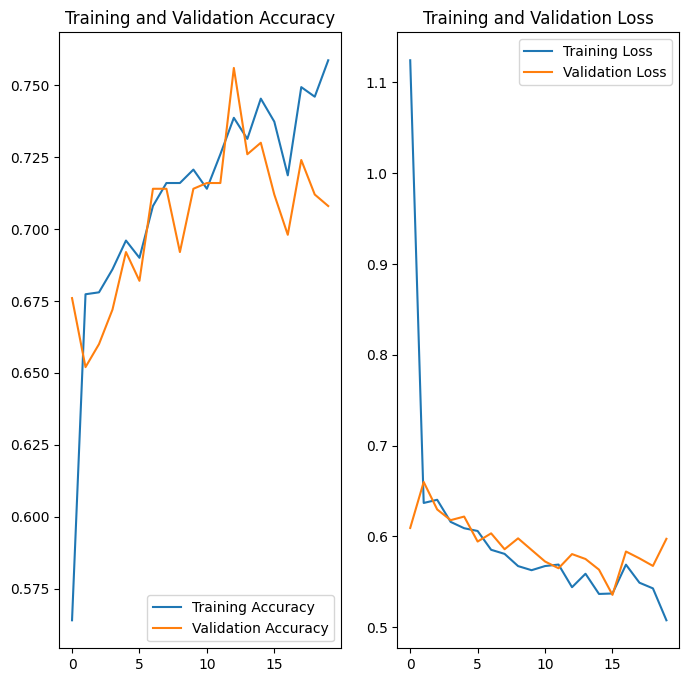

In [197]:
# plot the training and validation loss
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Make predictions with best model:

In [ ]:
# load saved model
test_model = keras.models.load_model('./best_model_checkpoint.hdf5')

In [ ]:
# load an image off disk
correct = 0
for i in range(10):
  img_index = random.randrange(2001, len(all_img_paths))
  img = load_and_preprocess_image(all_img_paths[img_index])

  print(img.shape) # before

  im_batch = tf.expand_dims(img, axis=0) # YOUR CODE HERE, use tf.expand_dims

  print(im_batch.shape) # after

  # make predictions
  batch_pred = test_model.predict(im_batch) # returns a list of predictions
  pred = batch_pred[0] 

  print("Prediction: ", round(pred[0]))
  print("Actual: ", all_bin_labels[img_index])
  display.display(display.Image(all_img_paths[img_index]))
  if round(pred[0]) == all_bin_labels[img_index]:
    correct += 1

print("")
print("Accuracy is: %d/10" % correct)

Try using a ResNet50 Model for transfer learning:

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [ ]:
efficientNet = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
efficientNet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# to save checkpoints of the model
checkpoint2 = ModelCheckpoint("best_efficientNet_model.hdf5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

In [ ]:
for each, label in test_ds.take(1):
  print(each.numpy().max())
  print(each.numpy().min())
  print(label)

In [ ]:
efficientNet_history = efficientNet.fit(train_ds, validation_data=test_ds, epochs=20, callbacks=[checkpoint2])

In [ ]:
my_model2 = models.Sequential()
my_model2.add(layers.Conv2D(64, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
my_model2.add(layers.MaxPooling2D())
my_model2.add(layers.Conv2D(128, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
my_model2.add(layers.MaxPooling2D())
my_model2.add(layers.Flatten())
my_model2.add(layers.Dense(128, activation="relu"))
my_model2.add(layers.Dense(1, activation="sigmoid"))

In [ ]:
my_model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = my_model2.fit(train_ds, validation_data=test_ds, epochs=15)

In [ ]:
# plot the training and validation loss
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Include Stratified Splitting:

In [ ]:
# DELETE LATER
train_paths, test_paths, train_labels, test_labels = train_test_split(small_img_paths, 
                                                                      small_bin_labels,
                                                                      stratify=small_bin_labels,
                                                                      test_size=0.25, 
                                                                      random_state=42)

In [ ]:
my_model3 = models.Sequential()
my_model3.add(layers.Conv2D(64, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
my_model3.add(layers.MaxPooling2D())
my_model3.add(layers.Conv2D(128, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
my_model3.add(layers.MaxPooling2D())
my_model3.add(layers.Flatten())
my_model3.add(layers.Dense(128, activation="relu"))
my_model3.add(layers.Dense(1, activation="sigmoid"))

In [ ]:
my_model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
checkpoint3 = ModelCheckpoint("best_stratified_model.hdf5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

In [ ]:
history3 = my_model3.fit(train_ds, validation_data=test_ds, epochs=15, callbacks=[checkpoint3])

In [ ]:
# plot the training and validation loss
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()